# Project!
## Business Question: 
### By David Shin and Khyatee Desai<br>Nov. 13, 2020

In [206]:
from zipfile import ZipFile 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle 
from itertools import combinations
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
set_config(print_changed_only=False, display=None)
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [207]:
# extract relevant csv files from zipped folder
with ZipFile("data/datasets.zip") as z:
    df = pd.read_csv(z.open(z.infolist()[0].filename))
#     df_artist = pd.read_csv(z.open(z.infolist()[1].filename))
#     df_avg_genre = pd.read_csv(z.open(z.infolist()[2].filename))
#     df_yr = pd.read_csv(z.open(z.infolist()[3].filename))
    df_genre = pd.read_csv(z.open(z.infolist()[4].filename))

In [208]:
df.sample(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
2342,0.55600,"['Bobby ""Boris"" Pickett', 'The Crypt-Kickers']",0.572,174000,0.608,0,1CHOyekPiL1z2Yu9S6ecea,0.000004,9,0.3190,-10.442,1,Rabian The Fiendage Idol,11,1962,0.1530,136.301,0.897,1962
60107,0.00542,['Rush'],0.668,250827,0.666,0,7DshKraD7yoFXH4BByAcIs,0.119000,0,0.0779,-10.866,1,Hand Over Fist - 2004 Remaster,28,1989-11-21,0.0284,119.751,0.543,1989
27829,0.81200,['Wings'],0.654,223640,0.416,0,3UtnWZDrOITKptmSgmaN1o,0.000037,2,0.9780,-13.112,0,Bluebird - Live / Remastered,31,1976-12-10,0.0288,94.529,0.677,1976


In [209]:
#Check for NA Values
rock_df.isna().sum().any()

False

In [210]:
#Review datatypes in table
rock_df.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
popularity            int64
speechiness         float64
tempo               float64
valence             float64
era                  object
scaled_loudness     float64
scaled_tempo        float64
scaled_speech       float64
scaled_val          float64
scaled_pop          float64
dtype: object

In [211]:
# drop irrelevant features
df_genre = df_genre[['artists', 'genres']]
df_genre.sample(3)

,artists,genres
15786,Mary Chapin Carpenter,"['country', 'folk', 'folk rock', 'lilith', 'me..."
23405,The Art Of Noise,"['dance rock', 'new romantic', 'new wave', 'ne..."
2761,Black Kids,"['alternative dance', 'dance-punk', 'indietron..."


### Join together main and genres dataframes

In [212]:
# unpack lists in the Artists column, retain the first artist of the list
df['artists'] = df['artists'].str.slice(1,-1).str.split(',')
df['artists'] = df['artists'].map(lambda x: x[0])
df['artists'] = df['artists'].str.slice(1,-1)

In [213]:
merged =df.merge(df_genre, on='artists')

# Keep rows within 'rock' genre
rock_df =merged[merged['genres'].str.contains('rock')]
rock_df.sample(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,genres
92762,0.9490,Sarah McLachlan,0.532,270400,0.0744,0,3xZMPZQYETEn4hjor3TR1A,0.000012,1,0.1060,-16.092,1,Angel,68,1997-08-29,0.0355,117.131,0.125,1997,"['canadian pop', 'canadian singer-songwriter',..."
72421,0.0932,Creedence Clearwater Revival,0.626,145533,0.8720,0,1WOyK0LGKxp2tXWd6mhuxL,0.239000,4,0.5120,-7.270,1,Don't Look Now - Live,46,1980-12,0.0419,103.322,0.656,1980,"['album rock', 'classic rock', 'country rock',..."
79952,0.0431,"""Weird Al"" Yankovic",0.826,217387,0.6940,0,2CstSu0GDI4dUFtE3VdubW,0.000000,4,0.0975,-10.265,1,(This Song's Just) Six Words Long,35,1988-01-01,0.0614,150.018,0.966,1988,"['antiviral pop', 'comedy rock', 'comic', 'par..."


### Target Variable Binning

In [214]:
# Create target variable based on year ranges
conditions = [
    (rock_df['year'] >=1950) & (rock_df['year'] <1970),
    (rock_df['year'] >=1970) & (rock_df['year'] <1990),
    (rock_df['year'] >=1990) & (rock_df['year'] <2010)]
choices = [
    '50s/60s', '70s/80s', '90s/2000s']
rock_df['era'] = np.select(conditions, choices, default='NA')

In [215]:
# drop rows with dates outside the relevant ranges
rock_df = rock_df[rock_df['era'] !='NA']

# drop irrelevant features
rock_df.drop(['artists', 'id', 'name', 'release_date', 'genres', 'year'], axis=1, inplace=True)

In [216]:
y = rock_df['era']
X = rock_df.drop(['era'], axis=1)

### Impute Outliers

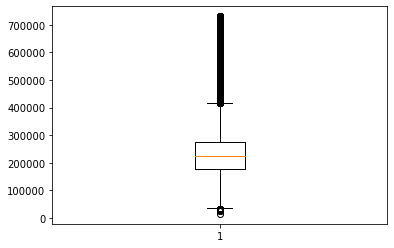

In [217]:
# Bring outliers down/up to 5 standard deviations from the mean
for feat in X:
    abv_5_std = X[feat].mean()+ 5*X[feat].std()
    below_5_std = X[feat].mean()- 5*X[feat].std()
    conditions = [X[feat]>abv_5_std, X[feat]<below_5_std]
    choices = [abv_5_std, below_5_std]
    X[feat] = np.select(conditions, choices, X[feat])

plt.boxplot(X.duration_ms);

# EDA

### Feature Scaling

In [218]:
loud = rock_df['loudness']
tempo = rock_df['tempo']
speech = rock_df['speechiness']
val = rock_df['valence']
pop = rock_df['popularity']
rock_df['scaled_loudness'] = (loud - min(loud)) / (max(loud) - min(loud))
rock_df['scaled_tempo'] = (tempo - min(tempo)) / (max(tempo) - min(tempo))
rock_df['scaled_speech'] = (speech - min(speech)) / (max(speech) - min(speech))
rock_df['scaled_val'] = (val - min(val)) / (max(val) - min(val))
rock_df['scaled_pop'] = (pop - min(pop)) / (max(pop) - min(pop))

In [219]:
#row, column count
rock_df.shape

(50496, 20)

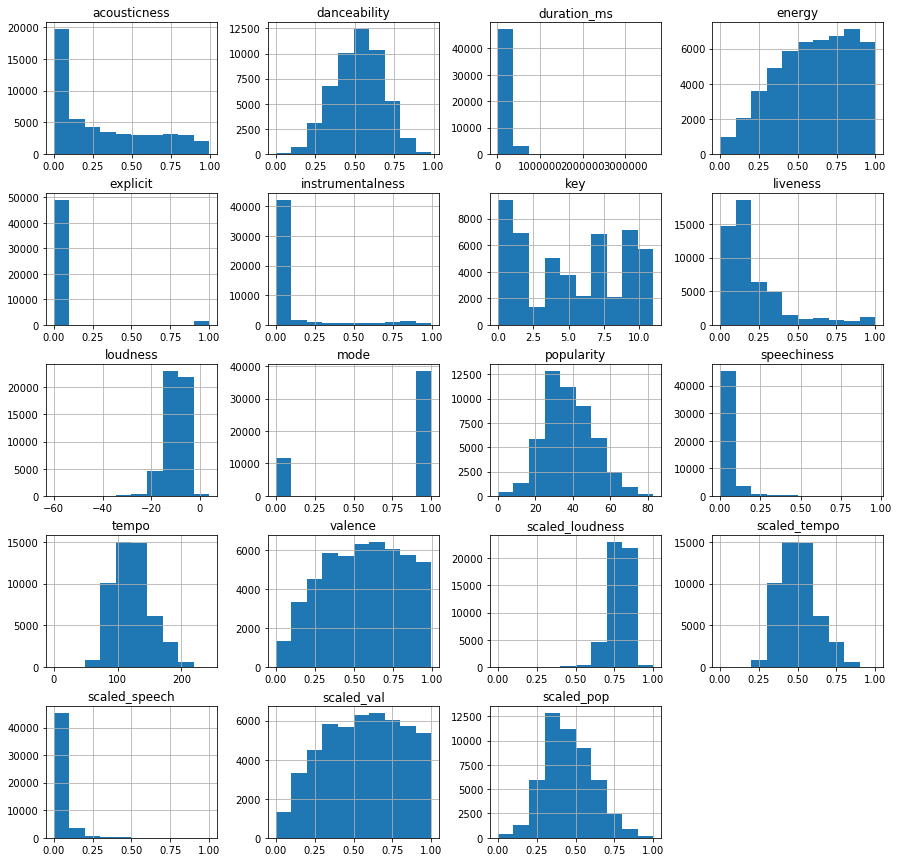

In [220]:
#Plot Histogram of all values
rock_df.hist(figsize=(15,15));

### Correlation Plot

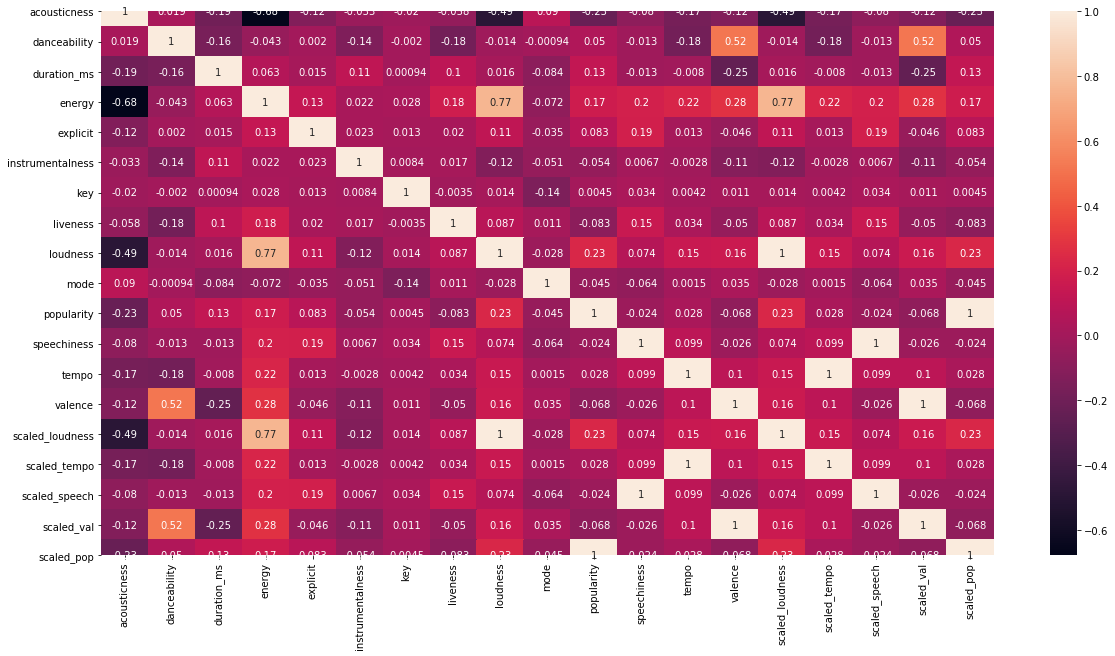

In [221]:
plt.figure(figsize=(20, 10))
sns.heatmap(rock_df.corr(),annot=True);

In [222]:
rock_df.groupby('era').mean()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,scaled_loudness,scaled_tempo,scaled_speech,scaled_val,scaled_pop
era,,,,,,,,,,,,,,,,,,,
50s/60s,0.524810,0.514813,186224.483184,0.493339,0.000418,0.074221,5.156257,0.206261,-11.105119,0.814915,27.555881,0.053066,118.552521,0.614965,0.767051,0.487125,0.055048,0.619300,0.331999
70s/80s,0.284077,0.525268,250006.081207,0.603942,0.011263,0.095978,5.156309,0.225283,-10.807004,0.757561,36.307971,0.055994,122.717807,0.571292,0.771727,0.504240,0.058085,0.575320,0.437445
90s/2000s,0.210889,0.526563,248788.713844,0.673714,0.068641,0.082682,5.257952,0.204978,-8.088355,0.748744,46.398390,0.058737,123.179978,0.507391,0.814377,0.506139,0.060930,0.510968,0.559017


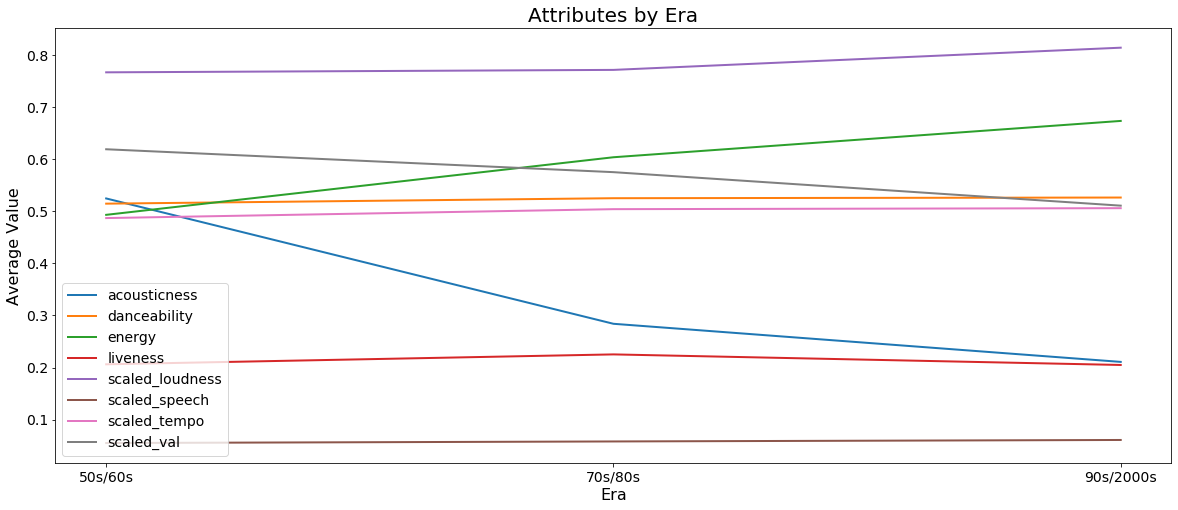

In [223]:
plt.figure(figsize=(20, 8))
attributes = ["acousticness","danceability","energy","liveness","scaled_loudness","scaled_speech","scaled_tempo","scaled_val"]
for attribute in attributes:
    x = rock_df.groupby("era")[attribute].mean()
    ax= sns.lineplot(x=x.index,y=x,label=attribute,linewidth = 2, seed=4)

ax.set_title('Attributes by Era', fontsize=20);
ax.set_ylabel('Average Value', fontsize=16);
ax.set_xlabel('Era', fontsize=16);
ax.legend(prop=dict(size=14));
ax.set_xticklabels(fontsize=14, labels=['50s/60s', '70s/80s', '90s/2000s']);
ax.set_yticklabels(fontsize=14, labels=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]);


Above chart shows the major attributes shown in our table by era. Upon initial inspection, some major changes throughout the era's are acousticness, energy, and valence. 

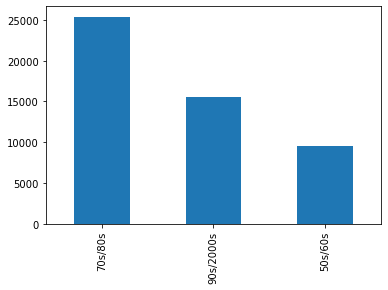

In [224]:
rock_df['era'].value_counts().plot(kind='bar');

The chart above shows that most of our target values lie in the 70's/80's era

## Plotting Specific Features
Based on the popularity distribution, we decided to remove popularity from the dataframe given that popularity is not a sound-based song attribute, and might be skewed due to spotify's younger demographic

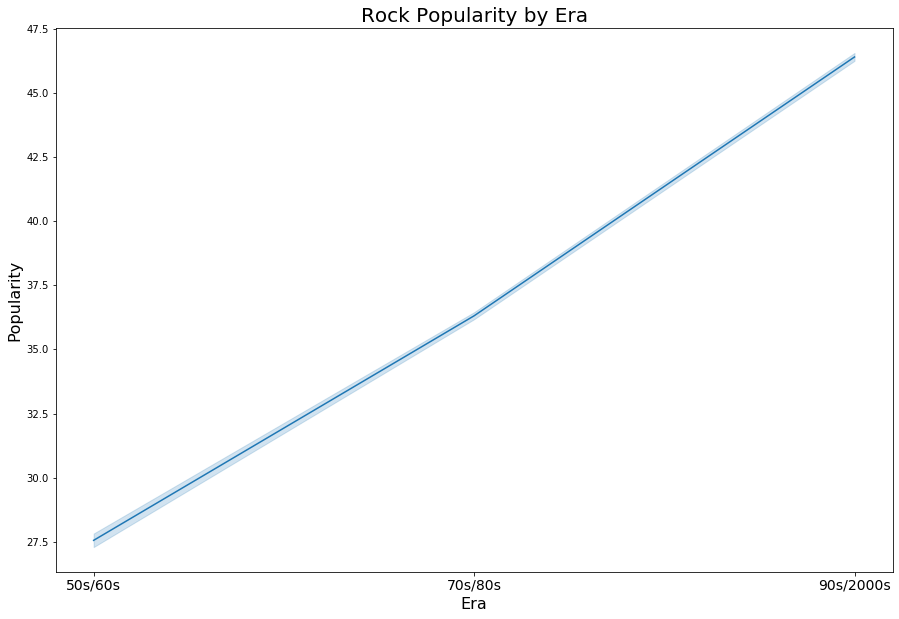

In [225]:
dffig,axes=plt.subplots(1,1,figsize=(15,10))
sns.lineplot(x='era',y='popularity',data=rock_df, palette="Blues");
axes.set_xlabel('Era', fontsize=16);
axes.set_ylabel('Popularity', fontsize=16);
axes.set_title('Rock Popularity by Era', fontsize=20);
axes.set_xticklabels(fontsize=14, labels=['50s/60s', '70s/80s', '90s/2000s']);

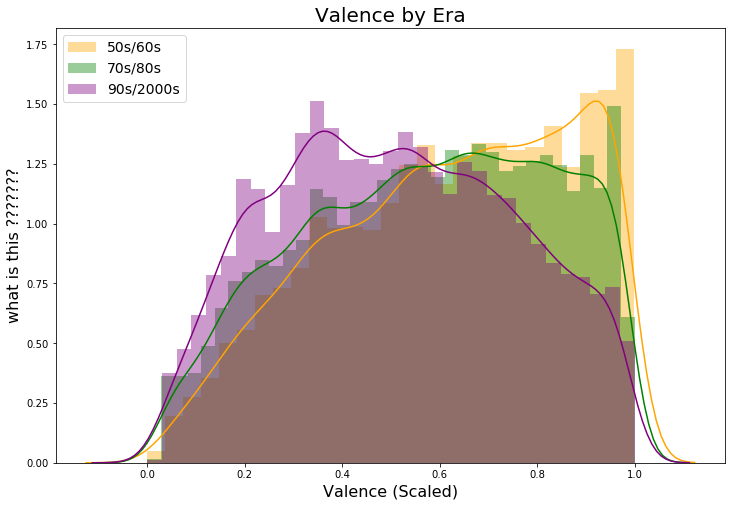

In [226]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df['scaled_val'][rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df['scaled_val'][rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df['scaled_val'][rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Valence by Era', fontsize=20);
ax.set_ylabel('what is this ???????', fontsize=16);
ax.set_xlabel('Valence (Scaled)', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a lower valence is more common for recent rock songs, whereas a higher valence is more common in the 50's-80's eras. 

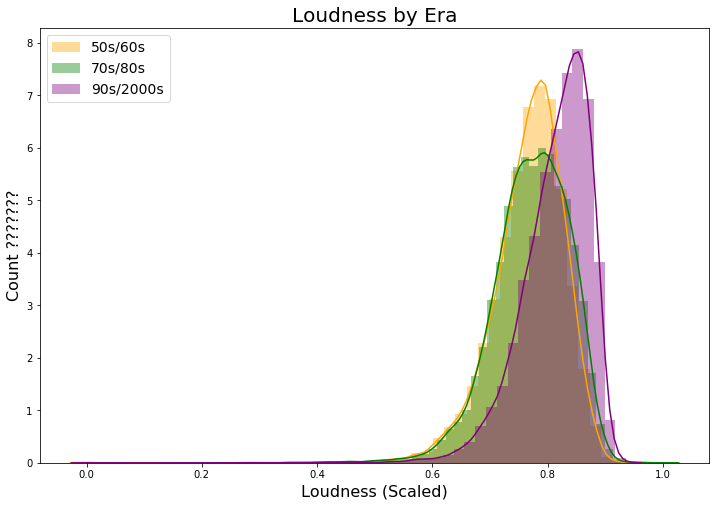

In [227]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df['scaled_loudness'][rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df['scaled_loudness'][rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df['scaled_loudness'][rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Loudness by Era', fontsize=20);
ax.set_ylabel('Count ???????', fontsize=16);
ax.set_xlabel('Loudness (Scaled)', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a higher loudness is more common for recent rock songs, whereas a lower loudness is more common in the 50's-80's eras. 

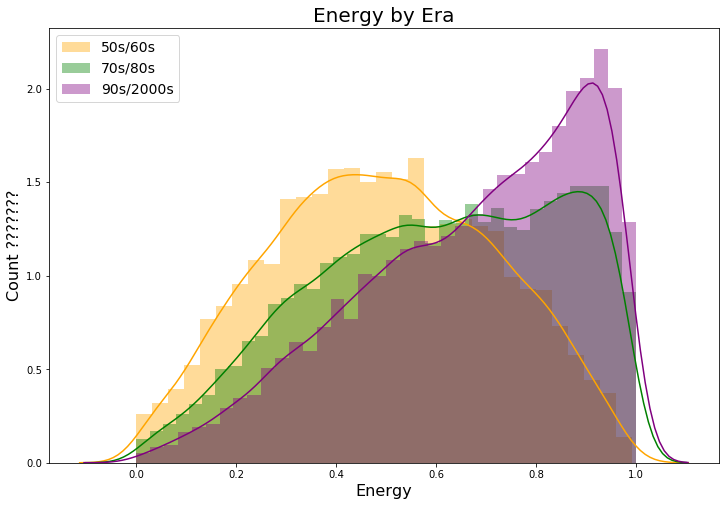

In [228]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df.energy[rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df.energy[rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df.energy[rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Energy by Era', fontsize=20);
ax.set_ylabel('Count ???????', fontsize=16);
ax.set_xlabel('Energy', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a higher energy is more common for recent rock songs, whereas a lower energy is more common in the 50's-60's eras. 

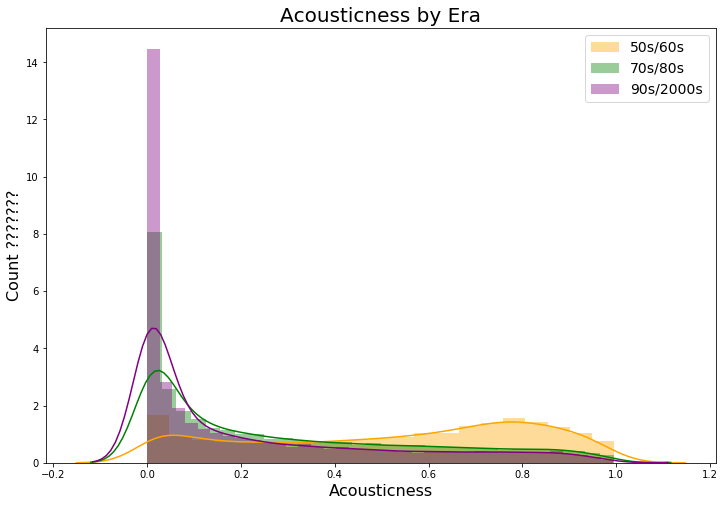

In [229]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df.acousticness[rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df.acousticness[rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df.acousticness[rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Acousticness by Era', fontsize=20);
ax.set_ylabel('Count ???????', fontsize=16);
ax.set_xlabel('Acousticness', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a acousticness was generally higher for recent rock songs in the 50s/60s era

# Feature Engineering

In [230]:
X.sample(3)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
87232,0.0328,0.478,204200.0,0.953,0.835139,0.000508,8.0,0.597,-7.294,1.0,50.0,0.089200,96.622,0.407
50223,0.6640,0.646,33267.0,0.469,0.000000,0.000043,11.0,0.108,-15.193,0.0,28.0,0.333194,123.344,0.708
96759,0.7660,0.532,304600.0,0.380,0.000000,0.000000,2.0,0.936,-11.008,1.0,53.0,0.031200,121.620,0.409


### Interaction Features

In [231]:
# Separate categorical and continuous features
cat_features = ['explicit', 'mode']
cont_features = X.drop(cat_features, axis=1).columns
X[cat_features] = X[cat_features].astype(int)

In [232]:
# Interaction Features
interactions = list(combinations(X[cont_features],2))

for combo in interactions:
    X[combo[0]+'_X_'+combo[1]] = X[combo[0]] * X[combo[1]]

### Log Variables

In [233]:
# Log Features
for feat in cont_features:
    X['log_'+feat] = X[feat].map(lambda x: np.log(x))
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

### Squared and Cubed Polynominals

In [234]:
# Polynomials
for feat in cont_features:
    X[feat+'^2'] = X[feat]**2
    X[feat+'^3'] = X[feat]**3

### Dummy Variables

In [235]:
key_dummies = pd.get_dummies(X['key'])
key_dummies.rename(columns = {0: 'key_C', 1: 'key_C#', 2:'key_D', 3:'key_Eb', 4:'key_E', 5:'key_F', 
                              6:'key_Gb', 7: 'key_G', 8:'key_Ab', 9:'key_A', 10:'key_Bb', 11:'key_B'}, inplace=True)
X.drop('key', axis=1, inplace=True)
X = pd.concat([X, key_dummies], axis=1)

# Feature Selection

We decided to drop the popularity feature, because it isn't a song attribute such as loudness/acousticness, and it tends to be biased towards newer music, given that Spotify users tend to be of a younger demographic.

In [236]:
X.drop('popularity', axis=1, inplace=True)

### Standardize

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

## Logistic Regression Model 
### with all features

In [238]:

logreg = LogisticRegression(C=1e5, class_weight='balanced')
logreg.fit(X_train, y_train)
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred))

Train F1: 0.6660692167683149
Test F1: 0.6678943028669249 

Train Accuracy: 0.666191381495564
Test Accuracy: 0.6679340937896071


### Select K-Best Features
found to make negligible difference, chose 71 bc it provides a high F1 with fewer features

In [239]:
k=71
selector = SelectKBest(k=k)
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

# Run logistic regression with 71 best features
logreg = LogisticRegression(C=1e5, class_weight='balanced')
logreg.fit(X_train_kbest, y_train)
y_train_pred = logreg.predict(X_train_kbest)
y_test_pred = logreg.predict(X_test_kbest)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.6647379488499208
Test F1: 0.6646391863554789


### Recursive Feature Elimination
Takes a long time to run, so we pickled the RFE feature list

In [240]:
# logreg = LogisticRegression(C=1e5, class_weight='balanced')
# selector = RFECV(estimator=logreg, step=1, cv=5, scoring='f1_weighted', n_jobs=-1)
# selector.fit(X_train, y_train)
# X_train_rfe = selector.transform(X_train)
# X_test_rfe = selector.transform(X_test)

# rfe_features = X.columns[selector.support_]
# pickle_out = open("pickled/rfe_features.pickle","wb")
# pickle.dump(rfe_features, pickle_out)
# pickle_out.close()

Train/Test Split and Scaling with only RFE Features

In [241]:
pickle_in = open("pickled/rfe_features.pickle","rb")
rfe_features = pickle.load(pickle_in)
pickle_in.close()
rfe_features = rfe_features.drop('popularity') # dropped popularity earlier, so need to reflect the change here


X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X[rfe_features], y, test_size=0.25, random_state=5)
scaler = StandardScaler() 
X_train_rfe = scaler.fit_transform(X_train_rfe)
X_test_rfe = scaler.transform(X_test_rfe)  

### Logistic Regression with RFE Features

In [242]:
logreg = LogisticRegression(C=1e5, class_weight='balanced')
logreg.fit(X_train_rfe, y_train)
y_train_pred = logreg.predict(X_train_rfe)
y_test_pred = logreg.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.6632363599017727
Test F1: 0.6626818814949237


## KNN Model
Loop to find optimal n value for KNN - determined to be 17

In [243]:
# for n in range(1,21):
#     knn = KNeighborsClassifier(n_neighbors=n)
#     knn.fit(X_train, y_train)
#     y_train_pred = knn.predict(X_train)
#     y_test_pred = knn.predict(X_test)
#     print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
#     print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'), 'for n:', n)

###  KNN with RFE features

In [244]:
# Best KNN Model (n=17)
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_rfe, y_train)
y_train_pred = knn.predict(X_train_rfe)
y_test_pred = knn.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.7150441258210658
Test F1: 0.6806178724941648


## Decision Tree
### With all features

In [245]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6, class_weight='balanced', )
tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.6539370976409138
Test F1: 0.6463386188420998


### With only RFE Features

In [246]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6, class_weight='balanced', )
tree.fit(X_train_rfe,y_train)
y_train_pred = tree.predict(X_train_rfe)
y_test_pred = tree.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.6590442992073947
Test F1: 0.6533410981192472


# Hyperparameter Tuning

### Tuning out KNN Model

In [250]:
#Determine Hyperparameters
knn_param_grid = {
    leaf_size=list(range(1,30)),
    n_neighbors = list(range(1,30)),
    p=[1,2]})

#Instantiate new KNN classifier
knn_tuning = KNeighborsClassifier()

#GridSearch
clf = GridSearchCV(knn_tuning, knn_param_grim, cv=10)

#Fit the model
knn_tuned_model = clf.fit(X_train,y_train)

#List best parameters
print("Best Parameters:")
clf.best_params_

NameError: name 'leaf_size' is not defined

In [ ]:
#determine parameters to test
clf = DecisionTreeClassifier()
param_grid = {
    'n_estimators' = [100,300,500,800,1000]
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15,20],
    'min_samples_split': [2, 5, 10, 15]}

#call gridsearch model and fit to data
grid_dt = GridSearchCV(clf, param_grid, cv=3)

#Fit the model
grid_dt.fit(X_train,y_train)

#List best parmameters
grid_dt.best_params_

# Model Evaluation

# Final Model & Conclusion